# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [1]:
!pip install -q transformers datasets tokenizers

     |████████████████████████████████| 5.8 MB 4.5 MB/s 
     |████████████████████████████████| 451 kB 46.6 MB/s 
     |████████████████████████████████| 7.6 MB 55.6 MB/s 
     |████████████████████████████████| 182 kB 53.2 MB/s 
     |████████████████████████████████| 212 kB 72.4 MB/s 
     |████████████████████████████████| 132 kB 65.2 MB/s 
     |████████████████████████████████| 127 kB 59.4 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as opt

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset
from google.colab import drive

from IPython.display import clear_output
clear_output()
import math


In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [4]:
emotion_dataset = load_dataset("emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [5]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
d_text = emotion_dataset["train"]['text'][:2000]
len(d_text)

2000

In [7]:
d_label  = emotion_dataset["train"]["label"][:2000]
len(d_label)

2000

In [8]:
emotion_dataset["train"]["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [9]:
emotion_dataset["train"]["label"][:5]

[0, 0, 3, 2, 3]

In [10]:
# посмотрим количество различных лейблов
print(len(set(emotion_dataset["train"]["label"]))) 

6


In [11]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [12]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [13]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [14]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [15]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [16]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [17]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [18]:
# Если надо, попрактикуйся работать с токенайзером здесь

In [19]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]["text"][idx]
        label = self.dataset[self.part]["label"][idx]
        
        tokenizer_output = self.tokenizer.encode_plus(text, max_length=self.max_length, padding="max_length", return_tensors="pt")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'], 
            "attention_mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [20]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation') # validation
test_dataset = TweetDataset('test')

In [21]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [22]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [23]:
LEARNING_RATE = 2e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
CLIP = 1

In [24]:
optimizer = torch.optim.Adam(model_0.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [25]:
train_data_iter = next(iter(train_loader))
tokens = train_data_iter['input_ids'].squeeze(1).to(device) # Получим токены из датасета
mask = train_data_iter['attention_mask'].squeeze(1).to(device)  # Получим маску из датасета
model_0(input_ids = tokens, attention_mask = mask).keys()  # Посмотрим на аутпут

odict_keys(['logits', 'past_key_values', 'attentions'])

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [ ]:
def fit_epoch(model, iterator, optimizer, criterion, scheduler, clip):
    model.train()
    epoch_loss = 0
    accuracy = 0
    target_size = 0
    for batch in tqdm(iterator):

        targets = batch['target'].to(device)
        tokens = batch['input_ids'].squeeze(1).to(device)
        mask  = batch['attention_mask'].squeeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=tokens,attention_mask=mask,labels=targets).logits
        loss = criterion(outputs,targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = clip)
        optimizer.step()
        scheduler.step(loss)
        target_size += targets.size(0)
        epoch_loss += loss.cpu().item() * targets.size(0)
        preds = torch.argmax(outputs,dim=1)
        accuracy += torch.sum(preds==targets).cpu()
        
    print(f"\Train Loss: {epoch_loss / target_size},"
          f"\tTrain Acc: {accuracy / target_size}")

    return epoch_loss / target_size, accuracy / target_size

In [29]:
def eval_epoch(model, iterator, criterion, scheduler):
    
    model.eval()
    epoch_loss = 0
    accuracy = 0
    target_size = 0
    with torch.no_grad():
        for batch in tqdm(iterator):
            targets = batch['target'].to(device)
            tokens = batch['input_ids'].squeeze(1).to(device)
            mask  = batch['attention_mask'].squeeze(1).to(device)
            outputs = model(input_ids=tokens,attention_mask=mask,labels=targets).logits
            loss = criterion(outputs,targets)
            scheduler.step(loss)
            target_size += targets.size(0)
            epoch_loss += loss.cpu().item() * targets.size(0)
            preds = torch.argmax(outputs,dim=1)
            accuracy += torch.sum(preds==targets).cpu()

    print(f"\tValid Loss: {epoch_loss / target_size},"
          f"\tValid Acc: {accuracy / target_size}")
      
        
    return epoch_loss / target_size, accuracy / target_size


In [30]:
def train(train_loader, valid_loader, model, optimizer, criterion, scheduler, epochs, text):

    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = []

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            torch.cuda.empty_cache()
            train_loss, train_acc = fit_epoch(model, train_loader, optimizer, criterion, scheduler, CLIP)
            valid_loss, valid_acc = eval_epoch(model, valid_loader, criterion, scheduler)

            history.append((train_loss, train_acc, valid_loss, valid_acc))

            if valid_acc > best_acc:
                best_acc = valid_acc
                best_model_0 = model.state_dict()
                torch.save(model.state_dict(), text)

            pbar_outer.update(1)
            
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_0)

    return model, history

In [48]:
def predict(model, test_loader):
  test_acc = 0
  target_size = 0
  model.eval()
  with torch.no_grad():
      for batch in test_loader:
          targets = batch['target'].to(device)
          tokens = batch['input_ids'].squeeze(1).to(device)
          mask = batch['attention_mask'].squeeze(1).to(device)
          outputs = model(input_ids=tokens,attention_mask=mask,labels=targets).logits
          target_size += targets.size(0)
          preds = torch.argmax(outputs,1)
          test_acc += torch.sum(preds==targets).cpu()

  test_epoch = test_acc / target_size
  print(f"Test Acc: {test_epoch}")

  return test_epoch

In [33]:
epochs = 15
model_0_train, history_0_train = train(train_loader, valid_loader, model=model_0, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs = epochs, text = 'best_model_0.pt')

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


\Train Loss: 1.5197898268699646,	Train Acc: 0.40012499690055847


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 1.1863726425170897,	Valid Acc: 0.578000009059906


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.9788721234798431,	Train Acc: 0.6397500038146973


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.7055831966400147,	Valid Acc: 0.7524999976158142


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.5299177059531212,	Train Acc: 0.8098124861717224


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.42786412525177003,	Valid Acc: 0.8445000052452087


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.2805613382458687,	Train Acc: 0.8990625143051147


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.30269150948524476,	Valid Acc: 0.8955000042915344


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.1758980551660061,	Train Acc: 0.9366250038146973


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.2927173225879669,	Valid Acc: 0.8999999761581421


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.13359468645602465,	Train Acc: 0.9505624771118164


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.29795216822624204,	Valid Acc: 0.9085000157356262


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.11336686129495502,	Train Acc: 0.9556249976158142


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.30624737071990965,	Valid Acc: 0.9154999852180481


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.0878202146962285,	Train Acc: 0.9686874747276306


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.34942496395111083,	Valid Acc: 0.9089999794960022


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.07703527788072824,	Train Acc: 0.971875011920929


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.311474289059639,	Valid Acc: 0.9210000038146973


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.06479656576365232,	Train Acc: 0.9774374961853027


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.44879207634925844,	Valid Acc: 0.906000018119812


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.05982806984288618,	Train Acc: 0.9791874885559082


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.3395629653930664,	Valid Acc: 0.909500002861023


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.04820486465794965,	Train Acc: 0.9829999804496765


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.4171405037641525,	Valid Acc: 0.9150000214576721


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.04660641463776119,	Train Acc: 0.9850624799728394


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.4751641331315041,	Valid Acc: 0.909500002861023


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.04075562499114312,	Train Acc: 0.9863125085830688


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.4986909980773926,	Valid Acc: 0.9164999723434448


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.0424776090317755,	Train Acc: 0.9871875047683716


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.5038885383605957,	Valid Acc: 0.9035000205039978
Best val Acc: 0.921000


In [49]:
model_0_train.load_state_dict(torch.load('best_model_0.pt'))
test_acc_model_0 = predict(model_0_train, test_loader)

Test Acc: 0.8985000252723694


In [40]:
train_loss, train_acc, valid_loss, valid_acc = zip(*history_0_train)

In [41]:
def plot_(train_loss, train_acc, valid_loss, valid_acc):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  ax[0].plot(train_loss, label="train_loss")
  ax[0].plot(valid_loss, label="valid_loss")
  ax[0].legend(loc='best')
  ax[0].set_xlabel("epochs")
  ax[0].set_ylabel("loss")

  ax[1].plot(train_acc, label="train_accuracy")
  ax[1].plot(valid_acc, label="valid_accuracy")
  ax[1].legend(loc='best')
  ax[1].set_xlabel("epochs")
  ax[1].set_ylabel("loss")
  plt.show()

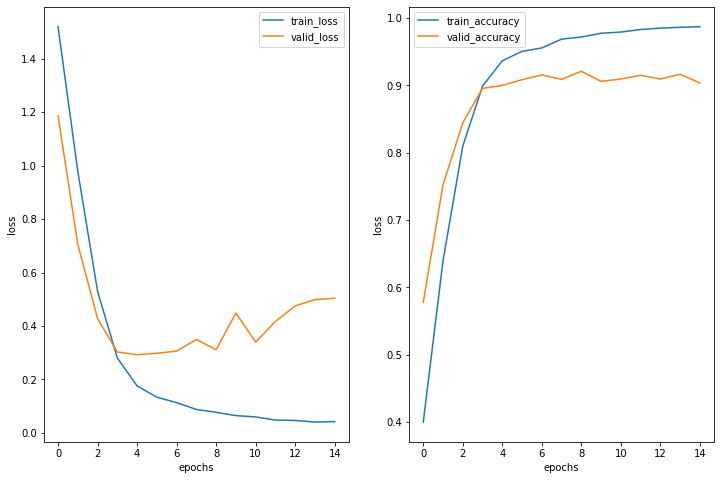

In [42]:
plot_(train_loss, train_acc, valid_loss, valid_acc)

После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [43]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [44]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [102]:
text = emotion_dataset["train"]["text"][555] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

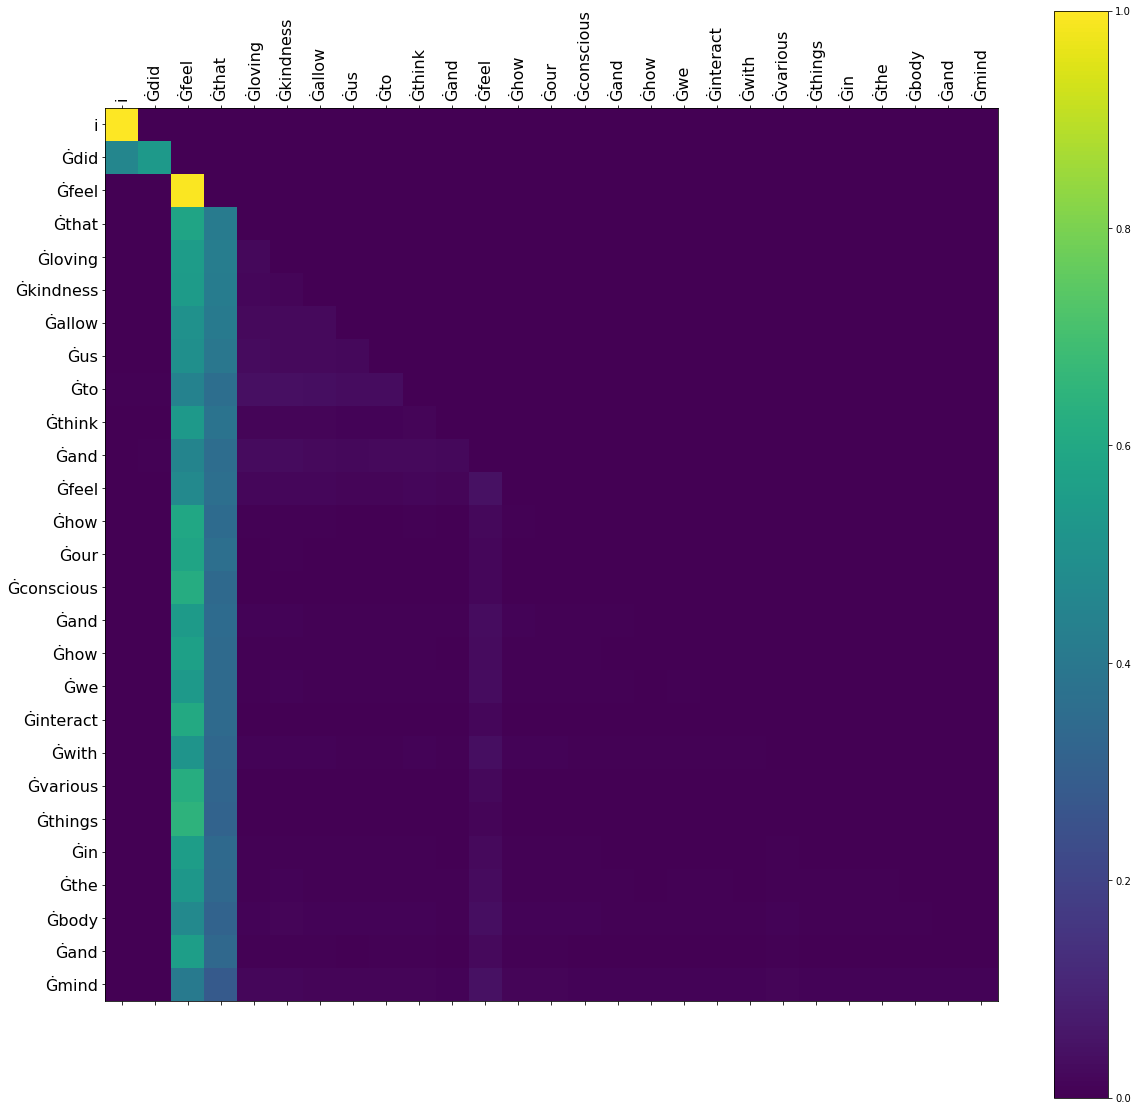

In [103]:
attns = get_attention_matrixes(model_0_train, tokenizer, text)
show_attention(tokens, attns[-1][0])

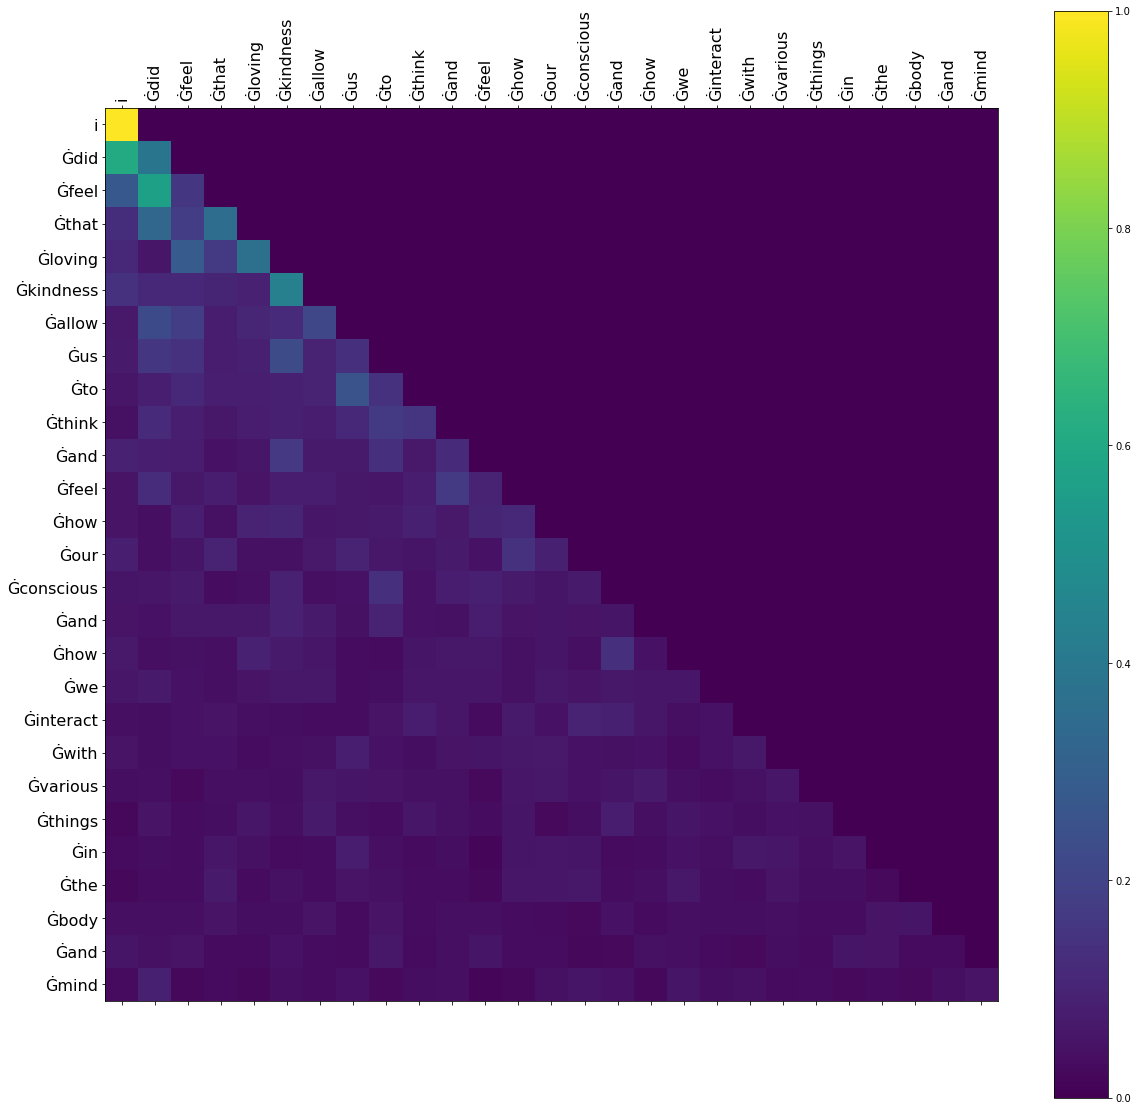

In [104]:
show_attention(tokens, attns[0][0])

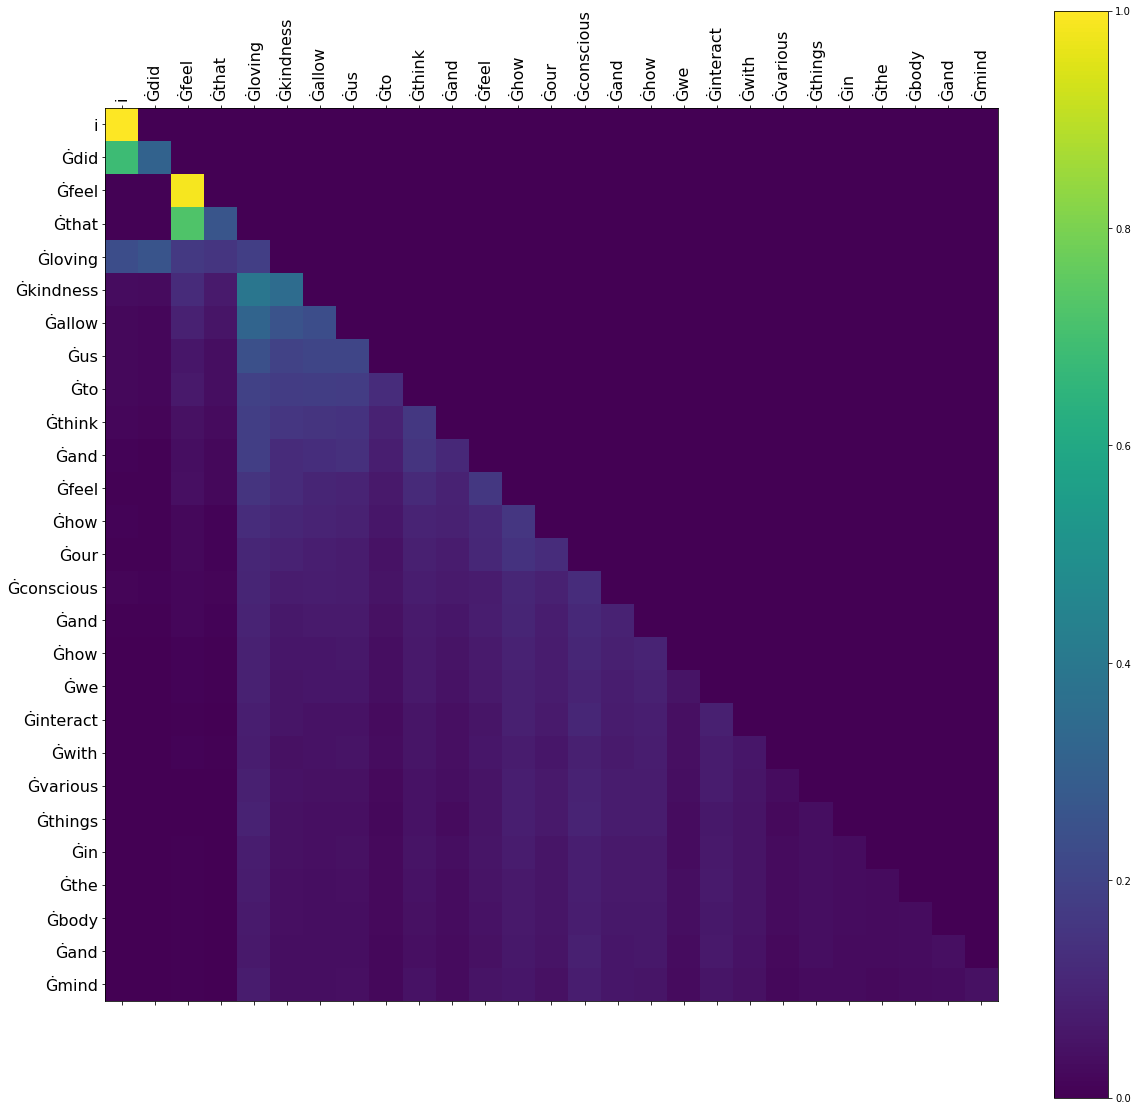

In [105]:
show_attention(tokens, attns[2][0])

## Вывод часть 1:
 

Видим, что на последнем слое голова смотрела сначала в основном на следующее слово, а потом сморела на одно и то же слово, точнее пару слов. На предыдущих слоях карты внимания заметно отлючаются.

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [52]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
LEARNING_RATE = 3e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)
CLIP = 2

In [54]:
optimizer = torch.optim.Adam(model_1.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [55]:
epochs = 10
model_1_train, history_1_train = train(train_loader, valid_loader, model=model_1, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs = epochs, text = 'best_model_1.pt')

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


\Train Loss: 0.9171719433069229,	Train Acc: 0.6664375066757202


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.2630018085241318,	Valid Acc: 0.9139999747276306


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.22740295138955116,	Train Acc: 0.9168750047683716


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.17733300578594208,	Valid Acc: 0.9275000095367432


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.15997643204033374,	Train Acc: 0.9318749904632568


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.13484564936161042,	Valid Acc: 0.9390000104904175


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.12595450830459595,	Train Acc: 0.9418749809265137


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.15043909895420074,	Valid Acc: 0.9309999942779541


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.10841360007226467,	Train Acc: 0.948312520980835


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.1438304654955864,	Valid Acc: 0.9369999766349792


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.09930752245336771,	Train Acc: 0.9521874785423279


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.13909092742204665,	Valid Acc: 0.9334999918937683


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.08945195729285478,	Train Acc: 0.9560624957084656


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.12814529979228972,	Valid Acc: 0.9424999952316284


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.08102858728915453,	Train Acc: 0.960562527179718


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.14091990622878076,	Valid Acc: 0.9375


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.07421641023270786,	Train Acc: 0.9629374742507935


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.1357421417236328,	Valid Acc: 0.9369999766349792


  0%|          | 0/250 [00:00<?, ?it/s]

\Train Loss: 0.06778420553170145,	Train Acc: 0.9667500257492065


  0%|          | 0/32 [00:00<?, ?it/s]

	Valid Loss: 0.14059590253233908,	Valid Acc: 0.9355000257492065
Best val Acc: 0.942500


In [56]:
test_acc_model_1 = predict(model_1_train, test_loader)

Test Acc: 0.9265000224113464


In [57]:
train_loss_1, train_acc_1, valid_loss_1, valid_acc_1 = zip(*history_1_train)

In [58]:
def plot_(train_loss, train_acc, valid_loss, valid_acc):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  ax[0].plot(train_loss_1, label="train_loss")
  ax[0].plot(valid_loss_1, label="valid_loss")
  ax[0].legend(loc='best')
  ax[0].set_xlabel("epochs")
  ax[0].set_ylabel("loss")

  ax[1].plot(train_acc_1, label="train_accuracy")
  ax[1].plot(valid_acc_1, label="valid_accuracy")
  ax[1].legend(loc='best')
  ax[1].set_xlabel("epochs")
  ax[1].set_ylabel("loss")
  plt.show()

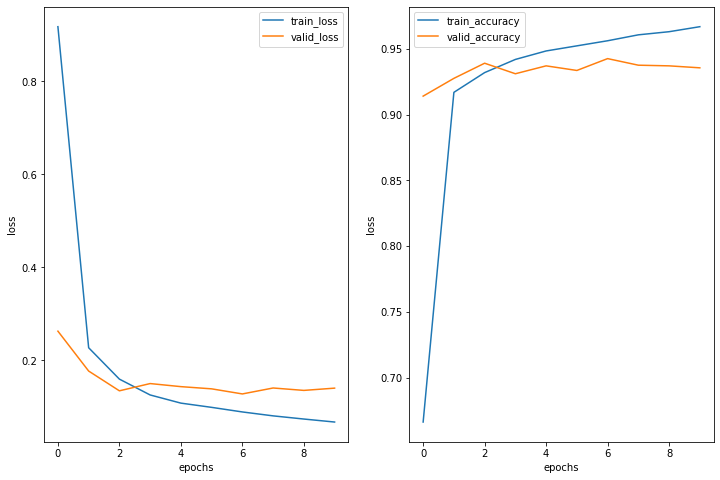

In [59]:
plot_(train_loss_1, train_acc_1, valid_loss_1, valid_acc_1)

Есть ли прирост качества или скорости обучения?

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

In [106]:
text = emotion_dataset["train"]["text"][555] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

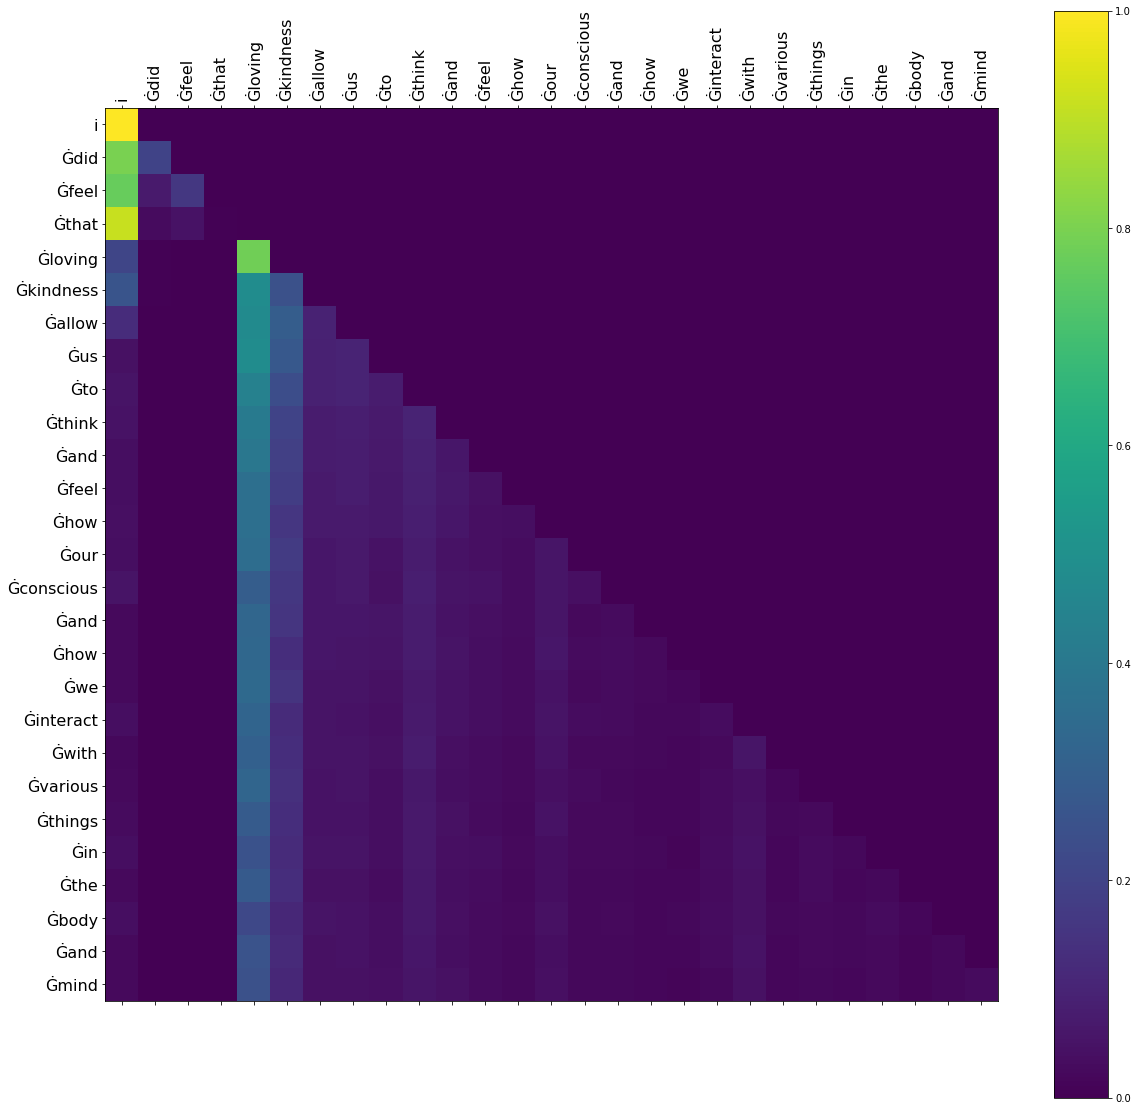

In [109]:
attns = get_attention_matrixes(model_1_train, tokenizer, text)
show_attention(tokens, attns[-1][0])

## Вывод часть 2

У данной модели на последнем слое первой головы голова смотрит на первое слово и еще одно контекстное слово. Хотя опять же, на других слоях и головах ситуация иная. 

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

## ОТЧЕТ:

Для того, чтобы ответить на поставленные вопросы, воспроизведем карты внимания, как в семинаре с помощью библиотеки bertviz.

In [62]:
#from google.colab import drive

model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to('cpu')

#drive.mount('/content/drive/')

model_1.load_state_dict(torch.load('/content/best_model_1.pt', map_location=torch.device('cpu')))



Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [63]:
!pip install bertviz
from bertviz import head_view, model_view


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157 kB 4.6 MB/s 
     |████████████████████████████████| 1.3 MB 62.7 MB/s 
     |████████████████████████████████| 132 kB 72.2 MB/s 
     |████████████████████████████████| 79 kB 11.1 MB/s 
     |████████████████████████████████| 10.2 MB 57.4 MB/s 


In [64]:
text = emotion_dataset["train"]["text"][1]
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

In [68]:
text

'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'

In [65]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [66]:
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model_1(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [67]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>

## Вывод:

На визуализации видно, что на первых слоях и головах модель смотрит на разные слова, где-то раз за разом на предыдущее слово, но ближе к концу модель смотрит больше на первое слово в предложении и на несколько других контекстных слов. 

Что касается общего вывода, то fine-tuning модель показала чуть более лучшие результаты за меньшее количество эпох: 0.92 против 0.90 у обученной с нуля модели. 

На картах внимания видим, что на последнем слое предобученная модель сильнее смотрит на первое слово, тогда как обученная заново модель еще смотрит на предыдушие слова, а потом на контекст.